<a href="https://colab.research.google.com/github/zeliboba7/cvpr-2021-cxr-tutorial/blob/main/cvpr_2021_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring chest x-ray models

The aim of this colab is to explore a few models trained on chest x-rays and qualitatively investigate their performance.


You can see a video accompanying this notebook [here](https://alistairewj.github.io).

First, we'll need to install a few packages. Of particular note are:

* [torchxrayvision](https://github.com/mlmed/torchxrayvision) - A library which harmonizes data loading for a few larger chest x-ray datasets and provides pretrained models. You can also [read a bit about their findings regarding cross-domain generalization](https://arxiv.org/abs/2002.02497).
* [grad-cam](https://github.com/jacobgil/pytorch-grad-cam) - a PyTorch based package for calculating saliency maps.

In [46]:
!pip install torchxrayvision grad-cam==1.2.9 ttach

In [47]:
# import libraries
%matplotlib inline
import copy
import os
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_color_map
import cv2
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import resnet50

import torchxrayvision as xrv

from pytorch_grad_cam import GradCAM
# Other methods available: ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

There are four large chest x-ray datasets of interest:

* [ChestXray14 (AKA ChestXray8)](https://nihcc.app.box.com/v/ChestXray-NIHCC) - 112,120 frontal-view X-ray images of 30,805 unique patients from the NIH clinical center. Images are associated with 14 NLP derived labels.
* [PadChest](https://bimcv.cipf.es/bimcv-projects/padchest/) - 160,000 images from 67,000 patients. Has extensive manual and machine learning derived labels.
* [CheXpert](https://stanfordmlgroup.github.io/competitions/chexpert/) - 224,316 chest radiographs from 65,240 patients with 14 NLP derived labels.
* [MIMIC-CXR](https://physionet.org/content/mimic-cxr/) - 377,110 images from 65,379 patients. The original dataset is provided with 227,835 deidentified free-text radiographic studies. For convenience, [a derived dataset with the same 14 labels as CheXpert is provided](https://physionet.org/content/mimic-cxr-jpg/).

While all the datasets are publicly available, only the ChestXray14 dataset is truly open data. CheXpert and PadChest are restricted access, requiring registration and signing of an agreement (albeit this process is instant).
Finally, MIMIC-CXR requires completion of a human subjects training course and applying on PhysioNet, a process which usually takes 1-2 weeks.

We'll use the sample data from PadChest (which does not require registration).

Downloading...
From: https://drive.google.com/uc?id=1_mKm1hlqAbxDfvZRKAJjW4icZPqAXICD
To: /content/padchest_sample2.zip
100% 1.20G/1.20G [00:10<00:00, 111MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1WYuYC-p77joqAv7TDivS3zGMD3NqTk4T
To: /content/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv
100% 99.2M/99.2M [00:00<00:00, 220MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10MYqI3rjUkrWCpvgJrryNpNSBSRtc45E
To: /content/chest_x_ray_images_labels_sample.csv
100% 14.9k/14.9k [00:00<00:00, 20.6MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: h

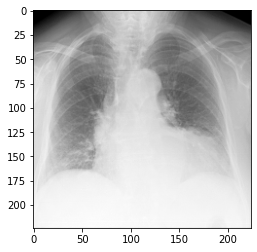

In [48]:
# download sample images from padchest sample 2
# see https://bimcv.cipf.es/bimcv-projects/padchest/
!gdown 1_mKm1hlqAbxDfvZRKAJjW4icZPqAXICD # images
!mv /content/padchest_sample2.zip /content/padchest/
!unzip -qo /content/padchest/padchest_sample2.zip -d /content/padchest/
!gdown 1WYuYC-p77joqAv7TDivS3zGMD3NqTk4T # labels from ML drive
!mv /content/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv /content/padchest/

# download sample images from padchest

# labels
!gdown --id 10MYqI3rjUkrWCpvgJrryNpNSBSRtc45E

# images
!gdown --id 1FJ8T2lYCtTxtfhatpcXBpXvEBx9gTf81

!mkdir -p /content/padchest
!mv /content/chest_x_ray_images_labels_sample.csv /content/padchest/
!mv /content/sample.zip /content/padchest/
!unzip -qo /content/padchest/sample.zip -d /content/padchest/

pc_path = Path('/content/padchest')
labels = pd.read_csv(pc_path / 'PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv')

# define a transform to convert images to 224x224
tr = transforms.Compose(
    [xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(224, engine='cv2')]
)

# the dataset object from torchxrayvision
d_pc = xrv.datasets.PC_Dataset(
    imgpath=pc_path,
    views=["PA","AP"],
    unique_patients=False,
    transform=tr
)

# the dataset expects all images to be available, so we'll create a function to index it
idx = d_pc.csv['ImageID'].str.startswith('100469495785351489872749036114751610212')
idx = np.where(idx)[0][0]
print(f'Found image at index {idx}.')
sample = d_pc[idx]
plt.imshow(sample['img'][0], cmap='Greys_r')
plt.show()

In [49]:
def get_image_index(dataset, image_id):
  if isinstance(dataset, xrv.datasets.PC_Dataset):
    idx = d_pc.csv['ImageID'] == image_id
  elif isinstance(dataset, xrv.datasets.MIMIC_Dataset):
    idx = np.where(d_m.csv['dicom_id'] == image_id)[0]
  else:
    raise ValueError('Unrecognized dataset %s' % dataset)

  idx = np.where(idx)[0]
  if len(idx) > 0:
    return idx[0]
  else:
    return None

As mentioned before, we'll use torchxrayvision to load a few example models.

In [50]:
# load a model trained on jfhealthcare
# !wget https://raw.githubusercontent.com/jfhealthcare/Chexpert/master/config/example.json -O /usr/local/lib/python3.7/dist-packages/torchxrayvision/baseline_models/jfhealthcare/config/example.json
# !wget https://github.com/mlmed/torchxrayvision/releases/download/v1/baseline_models_jfhealthcare-DenseNet121_pre_train.pth -O /usr/local/lib/python3.7/dist-packages/torchxrayvision/baseline_models/jfhealthcare/baseline_models_jfhealthcare-DenseNet121_pre_train.pth
# model = xrv.baseline_models.jfhealthcare.DenseNet()
models = OrderedDict()
cams = OrderedDict()

for model_name in ['chex', 'nih', 'pc', 'mimic_ch']:
  models[model_name] = xrv.models.DenseNet(weights=model_name)
  models[model_name].eval()

  target_layer = models[model_name].features[-1]
  # Construct the CAM object once, and then re-use it on many images:
  cam = GradCAM(model=models[model_name], target_layer=target_layer, use_cuda=False)
  cams[model_name] = cam
model_cmaps = [mpl_color_map.Purples, mpl_color_map.copper, mpl_color_map.Greens, mpl_color_map.Oranges]

We'll define a function that, given an activation map, overlays the map on the original x-ray.

In [51]:
def apply_colormap_on_image(org_im, activation, colormap_name, threshold=0.3):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
        threshold (float): threshold at which to overlay heatmap

    Original source: https://github.com/utkuozbulak/pytorch-cnn-visualizations

    Added thresholding to activations.
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4

    # set to fully transparent if there is a very low activation
    idx = (grayscale_cam <= threshold)
    # convert to a 3d index
    ignore_idx = np.expand_dims(np.zeros(grayscale_cam.shape, dtype=bool), 2)
    idx = np.concatenate([ignore_idx]*3 + [np.expand_dims(idx, 2)], axis=2)

    heatmap[idx] = 0
  
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on image
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

With that out of the way, let's look at the activation on a few choice images!

In [52]:
pc_image_ids = [f for f in os.listdir(pc_path) if f.endswith('.png')]
# only include samples in the dataset object - leaves us 15 images
pc_image_ids = [f for f in pc_image_ids if f in set(d_pc.csv['ImageID'].values)]

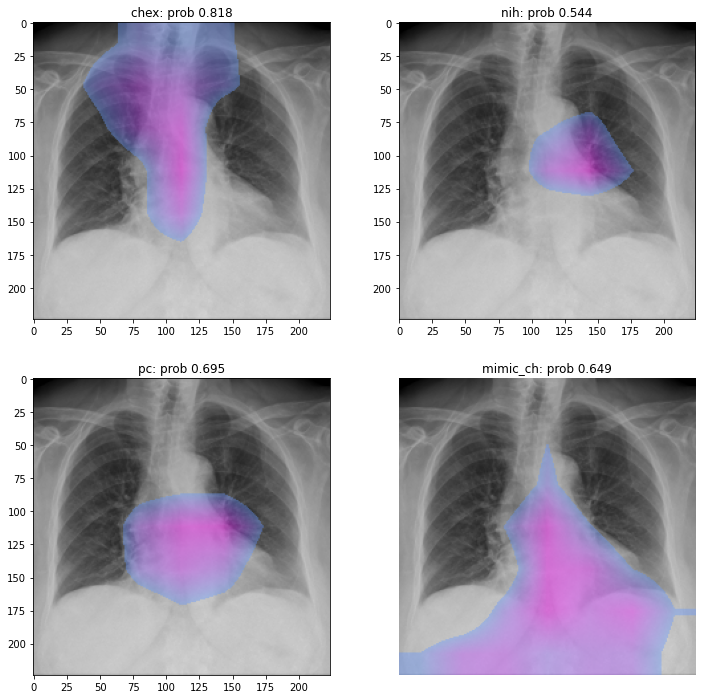

In [53]:
# choose which image
image_id = pc_image_ids[0]

# choose which pathology
# if None is put here, the most probable label is used
# options: 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
# 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
# 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia',
# target_category = model.pathologies.index('Enlarged Cardiomediastinum')
target = 'Cardiomegaly'

idx_sample = get_image_index(d_pc, pc_image_ids[0])
sample = d_pc[idx_sample]

input_tensor = torch.from_numpy(sample["img"]).unsqueeze(0)

# using the variable axs for multiple Axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
axs = (ax1, ax2, ax3, ax4)

i = 0
for model_name, model in models.items():
  # get our model performance
  with torch.no_grad():
      out = model(input_tensor).cpu()

  # finds the index of the target based on the model pathologies
  target_category = model.pathologies.index(target)

  grayscale_cam = cams[model_name](input_tensor=input_tensor, target_category=target_category)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]

  img = input_tensor.numpy()[0, 0, :, :]
  img = (img / 1024.0 / 2.0) + 0.5
  img = np.clip(img, 0, 1)
  img = Image.fromarray(np.uint8(img * 255) , 'L')
  _, heatmap_on_image = apply_colormap_on_image(img, grayscale_cam, 'cool', threshold=0.4)

  axs[i].imshow(heatmap_on_image, cmap='bone')

  # what did we predict?
  prob = np.round(out[0].detach().numpy()[target_category], 4)

  axs[i].set_title(f'{model_name}: prob {prob:0.3f}')

  i += 1
plt.axis('off')
plt.show()

When looking for the cardiomegaly label, we immediately see that the CheXpert and MIMIC-CXR trained models are looking outside the chest-wall, particularly at the top corners where often text information is written.

We can look at other images with known findings and see how the models compare.

In [54]:
for i, p in enumerate(pc_image_ids):
  idx = d_pc.csv['ImageID'] == p
  print(i, p)
  print(d_pc.csv.loc[idx, 'Labels'].values[0])

0 159364525876157332485573893353941089455_aepmh7.png
['aortic elongation', 'bronchiectasis', 'calcified densities', 'COPD signs', 'unchanged', 'cardiomegaly', 'vertebral degenerative changes']
1 47557396307760215809300057577936592627_m7mq32.png
['infiltrates', 'pacemaker', 'cardiomegaly']
2 162648608648453851477134030640090786312_97dr7j.png
['aortic atheromatosis', 'aortic elongation', 'cardiomegaly']
3 69949397621405752847745986326314413051_wai6lj.png
['aortic elongation', 'interstitial pattern', 'cardiomegaly']
4 152733907856972127971985724804321889809_u7ghw8.png
['unchanged', 'cardiomegaly', 'vascular hilar enlargement', 'diaphragmatic eventration']
5 114041240061582113028394479929792704149_u7xmxu.png
['scoliosis', 'COPD signs', 'cardiomegaly']
6 174600210814713315828954104869955154340_y7nqyx.png
['cardiomegaly']
7 10383960670432673238945376919735423432_hd3moq.png
['cardiomegaly']
8 62774794894109549387630855543283311955_2_tdirok.png
['supra aortic elongation', 'aortic elongation', 

114041240061582113028394479929792704149_u7xmxu.png
['scoliosis', 'COPD signs', 'cardiomegaly']

Looking for Pneumonia.


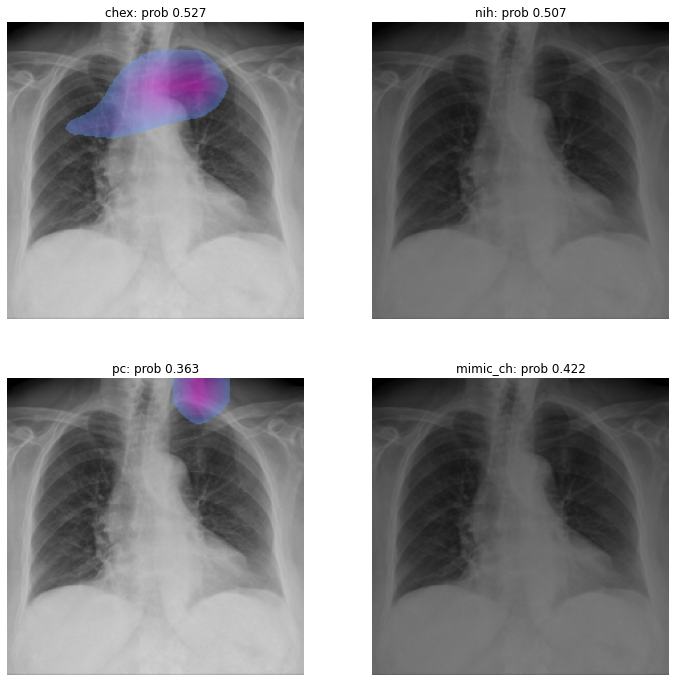

In [55]:
# choose which image
image_id = pc_image_ids[5]
print(image_id)
print(d_pc.csv.loc[d_pc.csv['ImageID'] == image_id, 'Labels'].values[0])

# choose which pathology
# if None is put here, the most probable label is used
# options: 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
# 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
# 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia',
# target_category = model.pathologies.index('Enlarged Cardiomediastinum')
target = 'Pneumonia'

idx_sample = get_image_index(d_pc, pc_image_ids[0])
sample = d_pc[idx_sample]

input_tensor = torch.from_numpy(sample["img"]).unsqueeze(0)
img = input_tensor.numpy()[0, 0, :, :]
img = (img / 1024.0 / 2.0) + 0.5
img = np.clip(img, 0, 1)
img = Image.fromarray(np.uint8(img * 255) , 'L')

# using the variable axs for multiple Axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
axs = (ax1, ax2, ax3, ax4)

print(f'\nLooking for {target}.')
i = 0
for model_name, model in models.items():
  # get our model performance
  with torch.no_grad():
      out = model(input_tensor).cpu()
    
  # reshape the dataset labels to match our model
  # xrv.datasets.relabel_dataset(model.pathologies, d_pc)

  # finds the index of the target based on the model pathologies
  target_category = model.pathologies.index(target)

  grayscale_cam = cams[model_name](input_tensor=input_tensor, target_category=target_category)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]

  _, heatmap_on_image = apply_colormap_on_image(img, grayscale_cam, 'cool', threshold=0.4)

  axs[i].imshow(heatmap_on_image, cmap='bone')

  # what did we predict?
  prob = np.round(out[0].detach().numpy()[target_category], 4)

  axs[i].set_title(f'{model_name}: prob {prob:0.3f}')
  axs[i].axis('off')
  i += 1

plt.show()

Again we can see some unusual behaviour from the models - only the one derived from MIMIC-CXR is actually highlighting areas within the lungs.

We can look at these saliency maps all on the same figure for better comparison.

114041240061582113028394479929792704149_u7xmxu.png
['scoliosis', 'COPD signs', 'cardiomegaly']

Looking for Pneumonia.
  chex: prob 0.527
  nih: prob 0.507
  pc: prob 0.363
  mimic_ch: prob 0.422


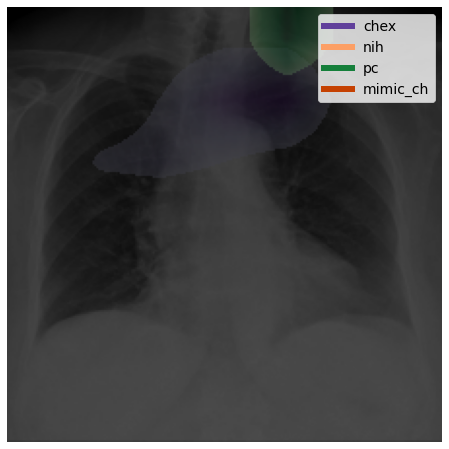

In [56]:
# choose which image
image_id = pc_image_ids[5]
print(image_id)
print(d_pc.csv.loc[d_pc.csv['ImageID'] == image_id, 'Labels'].values[0])

# choose which pathology
# if None is put here, the most probable label is used
# options: 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
# 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
# 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia',
# target_category = model.pathologies.index('Enlarged Cardiomediastinum')
target = 'Pneumonia'

idx_sample = get_image_index(d_pc, pc_image_ids[0])
sample = d_pc[idx_sample]

input_tensor = torch.from_numpy(sample["img"]).unsqueeze(0)
img = input_tensor.numpy()[0, 0, :, :]
img = (img / 1024.0 / 2.0) + 0.5
img = np.clip(img, 0, 1)
img = Image.fromarray(np.uint8(img * 255) , 'L')

# using the variable axs for multiple Axes
plt.figure(figsize=(10, 8))

print(f'\nLooking for {target}.')
i = 0
for model_name, model in models.items():
  # get our model performance
  with torch.no_grad():
      out = model(input_tensor).cpu()
    
  # reshape the dataset labels to match our model
  # xrv.datasets.relabel_dataset(model.pathologies, d_pc)

  # finds the index of the target based on the model pathologies
  target_category = model.pathologies.index(target)

  grayscale_cam = cams[model_name](input_tensor=input_tensor, target_category=target_category)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]

  _, img = apply_colormap_on_image(img, grayscale_cam, model_cmaps[i].name, threshold=0.4)


# axs[i].imshow(heatmap_on_image, cmap='bone')

  # add plot to add the color to the axis
  plt.plot(0, 0, '-', lw=6, color=model_cmaps[i](0.8), label=model_name)

  # what did we predict?
  prob = np.round(out[0].detach().numpy()[target_category], 4)
  print(f'  {model_name}: prob {prob:0.3f}')
  i += 1

plt.legend(fontsize=14)
plt.imshow(img, cmap='bone')
plt.axis('off')
plt.show()

## Try it with an image from the internet!

OpenI is a search engine provided by the National Library of Medicine for medical images (mostly sourced from public articles, but some datasets exist). In particular, Indiana University released a chest x-ray dataset of ~4000 images with reports, which we can play around with.

1. Go to: https://openi.nlm.nih.gov/gridquery?sub=x&m=1&n=100&it=xg
2. Click an image
3. Right click the image, and click "Copy Link Address"
4. Put the image address below, and see how the model do!

In [57]:

import subprocess
from skimage.io import imread

def normalize(sample, maxval):
    """
    Scales images to be roughly [-1024 1024].
    
    From torchxrayvision
    """
    
    if sample.max() > maxval:
        raise Exception("max image value ({}) higher than expected bound ({}).".format(sample.max(), maxval))
    
    sample = (2 * (sample.astype(np.float32) / maxval) - 1.) * 1024
    #sample = sample / np.std(sample)
    return sample

def read_image(image_path, tr=None):
  img = imread(image_path)
  img = img[:, :, 0]

  # Perform histogram equalization.
  img = cv2.equalizeHist(img.astype(np.uint8))
  img = normalize(img, 255)
  print(img.max())
  # Add color channel
  img = img[None, :, :]
  if tr is not None:                    
    img = tr(img)
  
  return img

def download_xray(image_link, image_name='downloaded-xray', tr=tr):
  """Download a chest x-ray and transform it."""
  # download the image to the filename provided
  subprocess.call(['wget', '-N', image_link, '-O', image_name])

  image = read_image(image_name, tr=tr)

  return image

1024.0

Looking for Pneumonia.
  chex: prob 0.014
  nih: prob 0.001
  pc: prob 0.107
  mimic_ch: prob 0.018


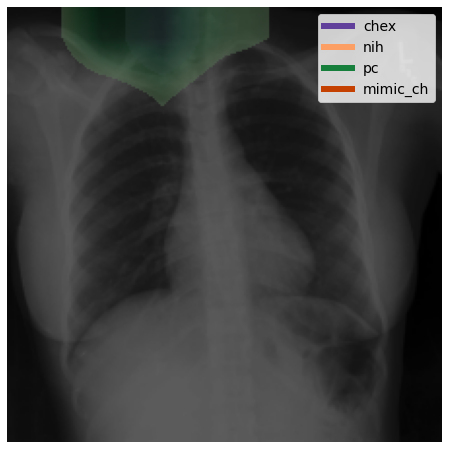

In [58]:
image_link = 'https://openi.nlm.nih.gov/imgs/512/1/1/CXR1_1_IM-0001-4001.png?keywords=normal'
target = 'Pneumonia'
image = download_xray(image_link, image_name='downloaded-xray', tr=tr)

input_tensor = torch.from_numpy(image).unsqueeze(0)

img = input_tensor.numpy()[0, 0, :, :]
img = (img / 1024.0 / 2.0) + 0.5
img = np.clip(img, 0, 1)
img = Image.fromarray(np.uint8(img * 255) , 'L')

# using the variable axs for multiple Axes
plt.figure(figsize=(10, 8))

print(f'\nLooking for {target}.')
i = 0
for model_name, model in models.items():
  # get our model performance
  with torch.no_grad():
      out = model(input_tensor).cpu()
    
  # reshape the dataset labels to match our model
  # xrv.datasets.relabel_dataset(model.pathologies, d_pc)

  # finds the index of the target based on the model pathologies
  target_category = model.pathologies.index(target)

  grayscale_cam = cams[model_name](input_tensor=input_tensor, target_category=target_category)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]

  _, img = apply_colormap_on_image(img, grayscale_cam, model_cmaps[i].name, threshold=0.4)

  # add plot to add the color to the axis
  plt.plot(0, 0, '-', lw=6, color=model_cmaps[i](0.8), label=model_name)

  # what did we predict?
  prob = np.round(out[0].detach().numpy()[target_category], 4)
  print(f'  {model_name}: prob {prob:0.3f}')
  i += 1

plt.legend(fontsize=14)
plt.imshow(img, cmap='bone')
plt.axis('off')
plt.show()